In [25]:
! pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
! pip3 install lightning
! pip3 install matplotlib

Looking in indexes: https://download.pytorch.org/whl/cu118


In [26]:
import os
import sys
import torch 
import pandas as pd
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
torch.set_float32_matmul_precision('high')

import pytorch_lightning as pl
from lightning.pytorch.loggers import MLFlowLogger

from torchmetrics import R2Score, MeanAbsoluteError, MeanSquaredError


In [27]:
path_to_package = os.path.abspath(os.path.join('..'))
if path_to_package not in sys.path:
    sys.path.append(path_to_package)
    
from src.utils.data_model_region import Region

In [28]:
# Global Constants
# Dataset
DATA_DIR_PATH = "./../data"
DATASET_PATH = f"{DATA_DIR_PATH}/PRSA2017_Data_20130301-20170228"
DATSET_PREPROCESSED_PATH = f"{DATA_DIR_PATH}/preprocessed"

# Model 
RANDOM_STATE = 1
PAST_WINDOW = 1
FUTURE_WINDOW = 1
BATCH_SIZE = 2048*16
TEST_SIZE = 0.4

DATE_COLUMNS = ['year','month','day']
POLUTION_FEATURES = ["PM2.5","PM10","SO2","NO2","CO","O3"]



def get_preprocessed_dataset_path(region:Region, base_path:str=DATSET_PREPROCESSED_PATH)->str|None:
    """Get path to pre-processed dataset

    Args:
        region (Region): Specifies the region of the dataset
        base_path (str, optional): root dir of the dataset. Defaults to DATASET_PATH.

    Raises:
        ValueError: incorrect region provided

    Returns:
        str|None: returns the datset file path for the region or raises error
    """
    if type(region) == Region:
        return f"{base_path}/{region.value}.csv"
    else:
        raise ValueError("Unkown REGION name!!!")

# load datset

In [29]:
regions_df = {}

for region in Region:
    # read datset
    regions_df[region] = pd.read_csv(get_preprocessed_dataset_path(region=region), index_col=None)
    # generate date
    regions_df[region]['date'] = pd.to_datetime(regions_df[region][DATE_COLUMNS])
    regions_df[region].drop(DATE_COLUMNS, axis=1, inplace=True)
    regions_df[region].drop('hour', axis=1, inplace=True)
    # group by daily and average
    regions_df[region] = regions_df[region].groupby('date').mean()
    # # set datetime index 
    # regions_df[region] = regions_df[region].set_index('date')

del region

In [30]:
# display sample
regions_df[Region.AOTIZHONGXIN]

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,N,S,E,W
date,,,,,,,,,,,,,,,
2013-03-01,7.125000,10.750000,11.708333,22.583333,429.166667,63.875000,1.391667,1026.875000,-18.745833,0.0,3.254167,1.000000,0.000000,0.291667,0.416667
2013-03-02,30.750000,42.083333,36.625000,66.666667,824.916667,29.750000,0.616667,1026.850000,-15.937500,0.0,1.479167,0.625000,0.208333,0.583333,0.375000
2013-03-03,76.916667,120.541667,61.291667,81.000000,1620.625000,19.125000,5.566667,1014.608333,-12.316667,0.0,1.658333,0.833333,0.083333,0.458333,0.375000
2013-03-04,22.708333,44.583333,23.015778,46.542748,595.019788,53.750000,9.962500,1017.650000,-11.683333,0.0,2.404167,0.500000,0.500000,0.208333,0.416667
2013-03-05,148.875000,183.791667,93.875000,132.833333,2357.958333,68.458333,6.291667,1010.900000,-7.525000,0.0,1.129167,0.833333,0.166667,0.708333,0.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-24,21.541667,32.625000,16.583333,58.875000,575.000000,50.791667,5.166667,1021.012500,-11.141667,0.0,1.595833,0.791667,0.083333,0.333333,0.625000
2017-02-25,11.208333,19.708333,6.750000,43.375000,420.833333,65.875000,7.245833,1018.812500,-10.754167,0.0,1.825000,0.750000,0.166667,0.083333,0.833333
2017-02-26,28.125000,40.708333,10.083333,65.375000,720.833333,48.625000,7.208333,1020.337500,-8.258333,0.0,1.566667,0.541667,0.416667,0.500000,0.416667


In [31]:
sliding_window_view(regions_df[Region.AOTIZHONGXIN]['CO'], 3)

array([[ 429.16666667,  824.91666667, 1620.625     ],
       [ 824.91666667, 1620.625     ,  595.01978754],
       [1620.625     ,  595.01978754, 2357.95833333],
       ...,
       [ 575.        ,  420.83333333,  720.83333333],
       [ 420.83333333,  720.83333333, 1364.02374136],
       [ 720.83333333, 1364.02374136,  420.83333333]])

In [32]:
regions_df[Region.AOTIZHONGXIN][regions_df[Region.AOTIZHONGXIN].index < '2016-03-01 00:00:00']

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,N,S,E,W
date,,,,,,,,,,,,,,,
2013-03-01,7.125000,10.750000,11.708333,22.583333,429.166667,63.875000,1.391667,1026.875000,-18.745833,0.0,3.254167,1.000000,0.000000,0.291667,0.416667
2013-03-02,30.750000,42.083333,36.625000,66.666667,824.916667,29.750000,0.616667,1026.850000,-15.937500,0.0,1.479167,0.625000,0.208333,0.583333,0.375000
2013-03-03,76.916667,120.541667,61.291667,81.000000,1620.625000,19.125000,5.566667,1014.608333,-12.316667,0.0,1.658333,0.833333,0.083333,0.458333,0.375000
2013-03-04,22.708333,44.583333,23.015778,46.542748,595.019788,53.750000,9.962500,1017.650000,-11.683333,0.0,2.404167,0.500000,0.500000,0.208333,0.416667
2013-03-05,148.875000,183.791667,93.875000,132.833333,2357.958333,68.458333,6.291667,1010.900000,-7.525000,0.0,1.129167,0.833333,0.166667,0.708333,0.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-02-25,22.583333,45.666667,9.375000,36.500000,741.666667,45.254554,2.504167,1028.320833,-17.254167,0.0,2.225000,0.625000,0.333333,0.250000,0.583333
2016-02-26,33.625000,60.541667,12.666667,33.166667,729.166667,54.875000,3.325000,1021.712500,-16.216667,0.0,2.383333,0.416667,0.500000,0.291667,0.708333
2016-02-27,20.541667,30.291667,8.750000,27.166667,579.166667,55.704416,4.108333,1020.495833,-10.937500,0.0,1.754167,0.583333,0.375000,0.500000,0.416667


In [33]:
def train_test_split(df:pd.DataFrame, feature:str, past_window:int, future_window:int, split_date:str='2016-03-01 00:00:00'):
    train_len = len(df[df.index < split_date]) 
    dataset_window = past_window + future_window
    sliding_window_dataset = sliding_window_view(df[feature], dataset_window)
    X_train = sliding_window_dataset[:train_len, :-future_window]
    X_test = sliding_window_dataset[train_len:, :-future_window]
    y_train = sliding_window_dataset[:train_len, -future_window:]
    y_test = sliding_window_dataset[train_len:, -future_window:]
    del sliding_window_dataset
    del dataset_window
    del train_len
    return X_train, X_test, y_train, y_test 

def get_test_feature_targets(df:pd.DataFrame, feature:str, split_date:str='2016-03-01 00:00:00'):
    return df[df.index >= split_date][feature].tolist()


# Linear regression

In [85]:
evaluations = []

for feature in POLUTION_FEATURES:
    # loop over diffrent size window
    for past_window in [1]:
        for future_window in [1]:
            # test train split
            X_train, X_test, y_train, y_test = train_test_split(regions_df[Region.AOTIZHONGXIN],feature,past_window,future_window)
            # build model
            regression_model = LinearRegression().fit(X_train, y_train)
            # make predictions
            y_predicted = regression_model.predict(X_test)
            # evaluate
            mae = metrics.mean_absolute_error(y_test, y_predicted)
            rmse = metrics.mean_squared_error(y_test, y_predicted, squared=False)
            r2 = metrics.r2_score(y_test, y_predicted)
            # store the results
            evaluation = [feature, past_window, future_window, mae, rmse, r2]
            evaluations.append(evaluation)

evaluations

[['PM2.5', 1, 1, 43.51574300537844, 59.93887087914887, 0.31354595530569673],
 ['PM10', 1, 1, 47.41266386938858, 64.24218368389754, 0.3028786313015934],
 ['SO2', 1, 1, 7.5862579942361705, 10.73998687153686, 0.22532579182197576],
 ['NO2', 1, 1, 18.035751445831522, 22.608160145673537, 0.4165822176652557],
 ['CO', 1, 1, 561.2242297973772, 839.4411494059716, 0.46754097115288906],
 ['O3', 1, 1, 18.43713896376188, 23.32948586436691, 0.6815367311710174]]

In [90]:
# test train split
X_train, X_test, y_train, y_test = train_test_split(regions_df[Region.AOTIZHONGXIN],"PM2.5",past_window*24,future_window)
lr = LinearRegression().fit(X_train, y_train)

In [91]:
X_train

array([[  7.125     ,  30.75      ,  76.91666667, ...,  90.41666667,
         52.75      ,  18.54166667],
       [ 30.75      ,  76.91666667,  22.70833333, ...,  52.75      ,
         18.54166667, 102.25      ],
       [ 76.91666667,  22.70833333, 148.875     , ...,  18.54166667,
        102.25      , 187.45833333],
       ...,
       [ 20.54166667,  35.54166667,  32.66666667, ...,  70.79166667,
         64.08333333, 129.91666667],
       [ 35.54166667,  32.66666667, 125.16666667, ...,  64.08333333,
        129.91666667, 118.33333333],
       [ 32.66666667, 125.16666667, 169.95833333, ..., 129.91666667,
        118.33333333,  20.54379571]])

In [92]:
y_target = get_test_feature_targets(regions_df[Region.AOTIZHONGXIN],'PM2.5')[24:(7+1)*24]

y_pred = X_test[0].tolist()

while len(y_target) > len(y_pred):
    prediction = np.round(lr.predict([y_pred[-24:]])[0][0])
    
    y_pred.append(prediction)

<Axes: title={'center': 'PM2.5 Forecats'}, xlabel='n-Step Ahead Forecast', ylabel='concentration(ug/m3)'>

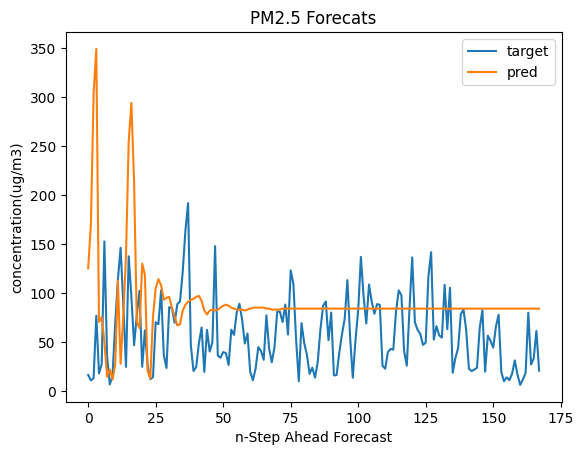

In [93]:
pd.DataFrame(data = {'target':y_target,'pred':y_pred,}).plot(title="PM2.5 Forecats",xlabel="n-Step Ahead Forecast", ylabel="concentration(ug/m3)")

In [38]:
365/24


15.208333333333334

In [39]:
# build evaluation dataset
evaluation_df = pd.DataFrame(
    data=evaluations,
    columns=["Feature", "Past Window", "Future Window", "MAE", "RMSE", "R2"]
)


In [40]:
evaluation_df

,Feature,Past Window,Future Window,MAE,RMSE,R2
0,PM2.5,1,1,41.157994,58.114250,0.299215
1,PM2.5,2,1,41.301786,58.850118,0.306601
2,PM2.5,3,1,42.961575,60.386287,0.302507
3,PM2.5,4,1,44.668015,62.864282,0.289162
4,PM2.5,5,1,46.955730,65.686450,0.272459
5,PM2.5,6,1,49.380551,68.962306,0.260696
6,PM2.5,7,1,52.225626,72.372720,0.253098
7,PM10,1,1,44.123571,62.010709,0.263321
8,PM10,2,1,43.932918,62.192747,0.258747
9,PM10,3,1,45.492732,63.417164,0.266430


In [41]:

print("1 Day predections evaluation")
evaluation_df[["Feature", "MAE", "RMSE", "R2"]].groupby("Feature").agg({
    'MAE': ['min','max','mean'],
    'RMSE': ['min','max','mean'],
    'R2': ['min','max','mean']
})

1 Day predections evaluation


MAE                                RMSE               \
                min         max        mean         min          max   
Feature                                                                
CO       531.706009  753.941012  621.724199  801.891719  1035.769967   
NO2       15.579280   20.645800   17.497235   20.777527    26.491228   
O3        15.224701   18.152916   17.119994   19.892921    23.039757   
PM10      43.932918   55.167703   48.441566   62.010709    75.945742   
PM2.5     41.157994   52.225626   45.521611   58.114250    72.372720   
SO2        5.213795    6.169111    5.524561    9.283676    10.840027   

                           R2                      
               mean       min       max      mean  
Feature                                            
CO       902.888967  0.435880  0.504019  0.473457  
NO2       23.185656  0.306487  0.513253  0.436581  
O3        21.833039  0.558960  0.731061  0.688202  
PM10      67.411643  0.214784  0.266430  0.244488  
PM2.5     63.890916  0.253098  0.306601  0.283391  
SO2        9.795685  0.258595  0.345923  0.310017

Text(0, 0.5, 'Future Window')

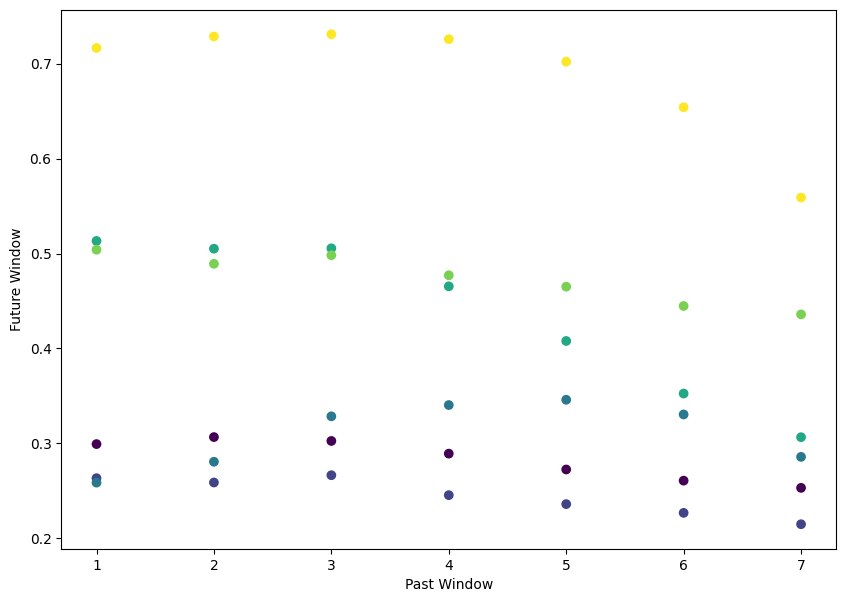

In [42]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes()#projection ="3d")

ax.scatter(
    x = evaluation_df["Past Window"], 
    # y = evaluation_df["Future Window"], 
    y = evaluation_df["R2"], 
    c = pd.factorize(evaluation_df["Feature"])[0],
    # colormap = 'viridis'
    # color=evaluation_df["Feature"],
)

ax.set_xlabel("Past Window")
ax.set_ylabel("Future Window")